In [1]:
from collections import defaultdict
import os
import pathlib
import pickle

from astropy.stats import median_absolute_deviation as MAD
from astropy.utils.misc import isiterable
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.stats import binned_statistic, binned_statistic_2d
from tqdm.notebook import tqdm
from scipy.spatial import cKDTree

from gala.mpl_style import turbo

import arviz as az
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
from scipy.stats import cauchy, norm
from scipy.special import logsumexp
import exoplanet as xo

In [2]:
figure_path = pathlib.Path('../tex/figures').resolve().absolute()

In [3]:
allstar_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allStar-dr17-synspec.fits')
allvisit_file = pathlib.Path(
    '/mnt/home/apricewhelan/data/APOGEE_DR17/allVisit-dr17-synspec.fits')

In [4]:
def get_bin_mask(allstar, **kwargs):
    bin_mask = np.ones(len(allstar), dtype=bool)
    
    for k, lim in kwargs.items():
        bin_mask &= (allstar[k] > lim[0]) & (allstar[k] < lim[1]) 
        
    return bin_mask


def equal_N_bins(x, N_per_bin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, N_per_bin + 1),
                     np.arange(npt),
                     np.sort(x))

Should use CCFWHM instad of VSINI, which is dropped for many stars?

1149210 482830 1149210


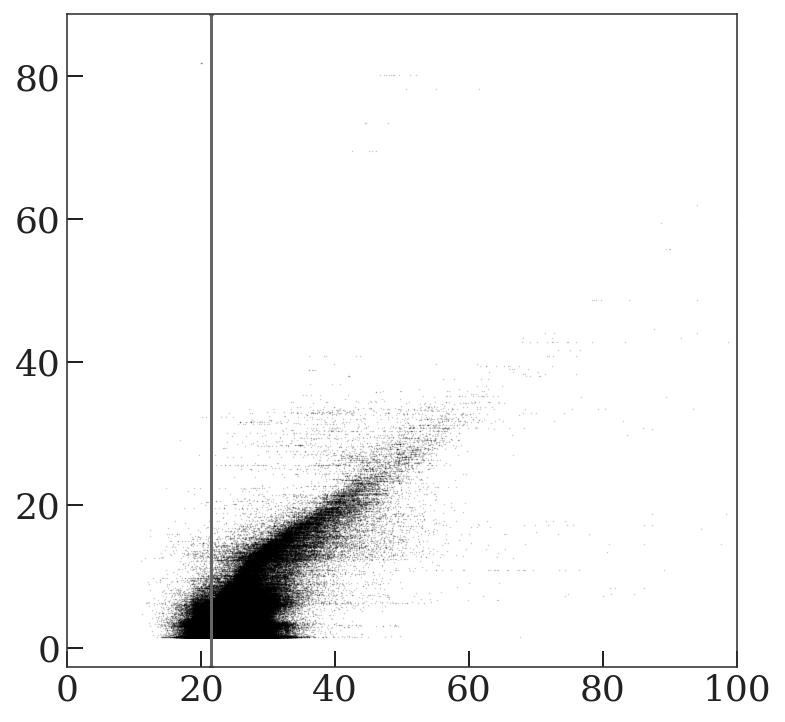

In [58]:
med_CCFWHM = np.median(test_visits['CCFWHM'])
plt.plot(test_visits['CCFWHM'], test_visits['VSINI'], ls='none', alpha=0.2, ms=1.5)
plt.xlim(0, 100)
plt.axvline(med_CCFWHM)

print(np.isfinite(test_visits['CCFWHM']).sum(), np.isfinite(test_visits['VSINI']).sum(), len(test_visits))

In [87]:
def get_visits(allstar, allvisit, **kwargs):
    bin_mask = get_bin_mask(
        allstar, **kwargs) 
    
    stars = allstar[bin_mask]
    visits = allvisit[np.isin(allvisit['APOGEE_ID'], stars['APOGEE_ID'])]
    
    if len(stars) < 1 or len(visits) < 1:
        return None, None
    
    visits = at.join(visits, stars['APOGEE_ID', 'VHELIO_AVG', 'TEFF', 'LOGG', 'M_H', 'VSINI'], 
                     keys='APOGEE_ID', join_type='left')
    visits = at.unique(visits, keys=('PLATE', 'MJD', 'FIBERID'))
    # visits['DVHELIO'] = visits['VHELIO'] - visits['VHELIO_AVG']
    
    df = visits['APOGEE_ID', 'VHELIO'].to_pandas()
    df['VHELIO_MEAN'] = df.groupby('APOGEE_ID')['VHELIO'].transform('mean')
    visits['DVHELIO'] = (df['VHELIO'] - df['VHELIO_MEAN']).values
    
    return stars, visits


def visits_to_data(visits, med_CCFWHM):
    data = {
        'vs': np.array(visits['DVHELIO']),
        # 'teffs' : np.array(visits['TEFF']),
        'snrs': np.array(visits['SNR']),
        'm_hs': np.array(visits['M_H']),
        # 'loggs': np.array(visits['LOGG']),
        # 'vsinis': np.array(visits['VSINI'])
        'ccfwhms': np.array(visits['CCFWHM']) - med_CCFWHM
    }
    
    for k in data:
        data[k]
    
    return data


def get_MAP_estimate(visits, model, med_CCFWHM, init_pars=None, **kwargs):
    if init_pars is None:
        init_pars = {
                'a_0': 0.05,
                'a_z1': -0.003,
                'b_0': 0.05,
                'b_z1': 1e-4,
                'b_vrot1': 0.01465298,
                'f_vrot': 0.09,
                'lnbs1': 1.6,
                'lnbs2': 4.5,
                'w': np.ones(K)
            }
        
    _pars = init_pars.copy()

    data = visits_to_data(visits, med_CCFWHM)
    
    kwargs.setdefault('progress', False)
    kwargs.setdefault('verbose', False)
    kwargs.setdefault('method', 'L-BFGS-B')
    
    for i in range(8):  # MAX ITER
        init_pars = {k: np.array(v) 
                     for k, v in _pars.items()}.copy()

        with model:
            pm.set_data(data)
            try:
                map_estimate = pmx.optimize(
                    start=init_pars, 
                    **kwargs)
                if np.all([np.all(np.isfinite(v)) for v in map_estimate.values()]):
                    break
            except Exception as e:
                print(f"FAILURE: iteration {i}")
                print(e)
                print(init_pars)
                return None
    
    return map_estimate

In [6]:
# DR17 
allstar = at.Table.read(allstar_file, hdu=1)
allstar = at.unique(allstar, keys='APOGEE_ID')

allvisit = at.Table.read(allvisit_file, hdu=1)

In [7]:
# BITMASK shiz
starflag_bits = np.array([
    3,  # VERY_BRIGHT_NEIGHBOR
    16,  # SUSPECT_RV_COMBINATION
    18,  # BAD_RV_COMBINATION
    19,  # RV_REJECT
    20,  # RV_SUSPECT
    21,  # MULTIPLE_SUSPECT
    22  # RV_FAIL
])
starflag_bitmask = np.sum(2**starflag_bits)

allstar = allstar[((allstar['ASPCAPFLAG'] & (2**23)) == 0) &  # STAR_BAD
                  ((allstar['STARFLAG'] & starflag_bitmask) == 0) &
                  (allstar['M_H'] > -2.5)]

starflag_mask = (allvisit['STARFLAG'] % starflag_bitmask) == 0

rvflag_bits = np.array([
    1,  # RV_BCFIT_FAIL
    3,  # RV_WINDOW_MASK
    4,  # RV_VALUE_ERROR
    5,  # RV_RUNTIME_ERROR
    6,  # RV_ERROR
    8,  # NO_GOOD_VISITS
    9,  # ALL_VISITS_REJECTED
    10,  # RV_REJECT
    11,  # RV_SUSPECT
])
rvflag_bitmask = np.sum(2**rvflag_bits)

# RV_FLAG and SB2
visit_rv_mask = ((allvisit['N_COMPONENTS'] == 1) & 
                 ((allvisit['RV_FLAG'] & rvflag_bitmask) == 0) &
                 (allvisit['SNR'] > 4) &
                 (np.isfinite(allvisit['VHELIO'])) &
                 (np.isin(allvisit['APOGEE_ID'], allstar['APOGEE_ID'])))

allvisit = allvisit[starflag_mask & visit_rv_mask]

In [8]:
min_nvisits = 3

allvisit = at.unique(allvisit, keys=('PLATE', 'MJD', 'FIBERID'))
apids, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)

allstar = allstar[np.isin(allstar['APOGEE_ID'], 
                          apids[counts >= min_nvisits])]
allvisit = allvisit[np.isin(allvisit['APOGEE_ID'], 
                            apids[counts >= min_nvisits])]

len(allstar), len(allvisit)

(233927, 1149210)

In [73]:
stars, visits = get_visits(
    allstar, allvisit,
    TEFF=(2000, 8000),
    LOGG=(-0.6, 6),
    M_H=(-3, 1))

In [10]:
_, counts = np.unique(allvisit['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

_, counts = np.unique(visits['APOGEE_ID'], return_counts=True)
assert counts.min() >= min_nvisits

assert np.all(visits['DVHELIO'] != 0)

In [11]:
# vsini_bins = [0, 4, 16, 32, 100]
# for l, r in zip(vsini_bins[:-1], vsini_bins[1:]):
#     vsini_mask = get_bin_mask(allstar, VSINI=(l, r))
#     fig, ax = plt.subplots(1, 1, figsize=(6, 6))

#     ax.hist2d(allstar['TEFF'][vsini_mask], allstar['LOGG'][vsini_mask], 
#               bins=(np.linspace(teff_ctrs.min(), teff_ctrs.max(), 128),
#                     np.linspace(logg_ctrs.min(), logg_ctrs.max(), 128)),
#               norm=mpl.colors.LogNorm(),
#               cmap='Blues');

#     ax.set_xlabel('TEFF')

#     ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
#     ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
#     ax.set_ylabel('LOGG')

#     fig.tight_layout()
#     fig.set_facecolor('w')

## Model:

$$
\begin{align}
Z &= 10^{[{\rm M}/{\rm H}]}\\
v^* &= \sqrt{(v\sin i)^2 + (c/R)^2}\\
\Delta Z &= (Z - Z_0)\\
a &= a_{0} + a_{Z, 1} \, \Delta Z\\
b &= b_{0} + b_{Z, 1} \, \Delta Z\\
\sigma_v^2 &= a^2 + b^2 \, \left( \frac{\rm SNR}{{\rm SNR}_0} \right)^{-2} + b_{v\sin i}^2 \, ((v\sin i)^2 + (c/R)^2)\\
\tilde{v} &\sim w_1 \, \mathcal{N}(0, \sigma_v^2) + 
    w_2 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2) + 
    w_3 \, \mathcal{N}(0, \sigma_v^2 + \sigma_{\rm bin, 1}^2 + \sigma_{\rm bin, 2}^2)
\end{align}
$$

In [12]:
from astropy.constants import c as speedoflight
R = 22500
vsini_floor = (speedoflight / R).to_value(u.km/u.s)

In [13]:
# _grid = np.linspace(1, 100, 128)
# # plt.plot(_grid, np.sqrt(6e-3**2 * (_grid**2 + vsini_floor**2)))
# plt.plot(_grid, np.sqrt(6e-3**2 * (_grid/vsini_floor)**2 + 0.05**2))

In [74]:
with pm.Model() as model:
    snr0 = pm.Data('snr0', 40.)
    Z0 = pm.Data('Z0', 1.)
    
    vs = pm.Data('vs', np.zeros(1))
    snrs = pm.Data('snrs', np.zeros(1))
    m_hs = pm.Data('m_hs', np.zeros(1))
    # vsinis = pm.Data('vsinis', np.zeros(1))
    ccfwhms = pm.Data('ccfwhms', np.zeros(1))
    
    # cluster sizes
    K = 3
    ws = pm.Dirichlet("w", a=np.ones(K), shape=K)

    Z = 10 ** m_hs
    dZ = Z - Z0
    b_vrot1 = pm.Bound(pm.Normal, lower=0.)('b_vrot1', 0, 0.1)
    f_vrot = pm.Bound(pm.Normal, lower=0)('f_vrot', 0, 0.1)
    # vsini_term = b_vrot1**2 * (vsinis**2 + f_vrot * vsini_floor**2)
    vsini_term = b_vrot1**2 * (ccfwhms**2 + f_vrot * vsini_floor**2)

    a_0 = pm.Normal('a_0', 0, 0.1)
    a_z1 = pm.Normal('a_z1', 0, 0.2)
    a = a_0 + a_z1 * dZ
    
    b_0 = pm.Normal('b_0', 0, 0.2)
    b_z1 = pm.Normal('b_z1', 0, 0.2)
    b = b_0 + b_z1 * dZ
    
    err1 = pm.Deterministic('err1', np.sqrt(a**2 + b**2 / (snrs / snr0)**2 + vsini_term))
    
    norm1 = pm.Normal.dist(0, err1)
    
    # binaries
    lnbs1 = pm.Uniform('lnbs1', -0.7, 4)
    binary_std1 = tt.exp(lnbs1)
    err2 = pm.Deterministic('err2', np.sqrt(err1**2 + binary_std1**2))
    norm2 = pm.Normal.dist(0, err2)
    
    # excess variance
    lnbs2 = pm.Uniform('lnbs2', 1.6, 5.5)
    binary_std2 = tt.exp(lnbs2)
    err3 = pm.Deterministic('err3', np.sqrt(err2**2 + binary_std2**2))
    norm3 = pm.Normal.dist(0, err3)

    # likelihood for each observed value
    like = pm.Mixture('like', 
                      w=ws, 
                      comp_dists=[norm1, norm2, norm3],
                      observed=vs)
    
    pm.Deterministic('logp1', norm1.logp(vs))
    pm.Deterministic('logp2', norm2.logp(vs))
    pm.Deterministic('logp3', norm3.logp(vs))

### Metric and grid setup

Overlapping bins, for a given star, take the box center closest to the star's position in logg, teff

In [61]:
teff_step = 400
logg_step = 0.4
# teff_step = 600
# logg_step = 0.6

teff_half_size = teff_step * 3 / 2
logg_half_size = logg_step * 3 / 2

teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
logg_ctrs = np.arange(-logg_step, 6+1e-3, logg_step)
# teff_ctrs = np.arange(3000, 8000+1e-3, teff_step)
# logg_ctrs = np.array([4.5])

teff_grid, logg_grid = np.meshgrid(teff_ctrs, logg_ctrs)

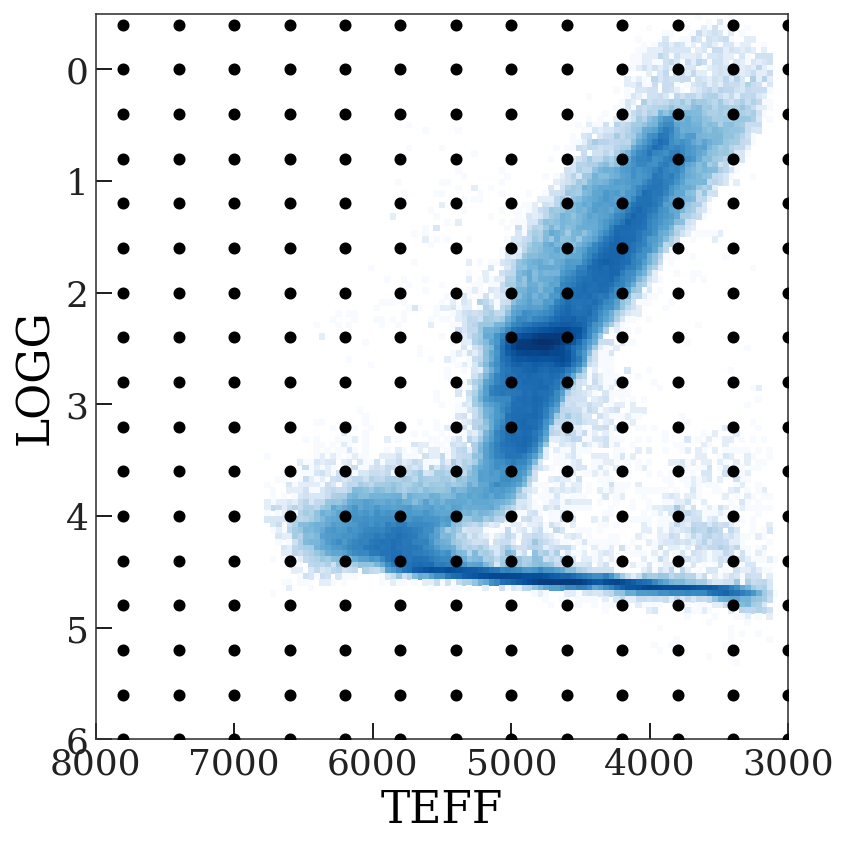

In [63]:
plot_teff_logg_bins = (np.linspace(3000, 8000, 128),
                       np.linspace(-0.5, 6, 128))

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(teff_grid.ravel(), 
           logg_grid.ravel(), 
           zorder=100)

ax.set_xlabel('TEFF')

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

In [64]:
pickle_file = pathlib.Path('../cache/logg_teff_grid_MAPs-vsini.pkl')
pickle_file.parent.mkdir(exist_ok=True)

# pickle_file = pathlib.Path('../cache/test.pkl')
# pickle_file.parent.mkdir(exist_ok=True)
# pickle_file.unlink(missing_ok=True)

In [76]:
overwrite = False
N_visit_min = 256
N_star_min = 64
map_estimate = None

if not pickle_file.exists() or overwrite:
    bin_means = []
    map_estimates = []
    for teff_val, logg_val in tqdm(zip(teff_grid.ravel(), 
                                       logg_grid.ravel()), total=teff_grid.size):
        teff_lim = (teff_val - teff_half_size, teff_val + teff_half_size)
        logg_lim = (logg_val - logg_half_size, logg_val + logg_half_size)
        stars, visits = get_visits(
            allstar, allvisit,
            TEFF=teff_lim,
            LOGG=logg_lim,
            M_H=(-2.5, 1))

        if stars is None or len(visits) < N_visit_min or len(stars) < N_star_min:
            continue

        print(f"TEFF: ({teff_lim[0]:.0f}, {teff_lim[1]:.0f}), " + 
              f"LOGG: ({logg_lim[0]:.1f}, {logg_lim[1]:.1f}), " + 
              f'N stars: {len(stars)},  N visits: {len(visits)}')
        
#         if map_estimate is not None:
#             map_estimate = get_MAP_estimate(visits, model, 
#                                             init_pars=map_estimate.copy())
#         else:
        map_estimate = get_MAP_estimate(visits, model, med_CCFWHM, verbose=True)
        
        if map_estimate is None:
            continue
        
        # NOTE: this is but one choice in the multiverse of choices
        # i.e. we might want to mean over visits instead!
        bin_means.append([
            stars['TEFF'].mean(), 
            stars['LOGG'].mean()
        ])
        
        map_estimates.append(map_estimate)

    bin_means = np.array(bin_means)
    
    with open(pickle_file, 'wb') as f:
        pickle.dump((bin_means, map_estimates), f)
        
with open(pickle_file, 'rb') as f:
    (bin_means, map_estimates) = pickle.load(f)

  0%|          | 0/221 [00:00<?, ?it/s]

TEFF: (2400, 3600), LOGG: (-1.0, 0.2), N stars: 388,  N visits: 2127


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5497.348319459907 -> -3032.080747237831


TEFF: (2800, 4000), LOGG: (-1.0, 0.2), N stars: 666,  N visits: 4255


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11046.921899162555 -> -6239.406173455767


TEFF: (3200, 4400), LOGG: (-1.0, 0.2), N stars: 665,  N visits: 4434


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11436.369591734454 -> -6582.6439196516085


TEFF: (3600, 4800), LOGG: (-1.0, 0.2), N stars: 323,  N visits: 2462


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6230.521442930117 -> -3679.5000324789216


TEFF: (2400, 3600), LOGG: (-0.6, 0.6), N stars: 1221,  N visits: 5529


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -13013.318978326613 -> -6700.798848970184


TEFF: (2800, 4000), LOGG: (-0.6, 0.6), N stars: 3788,  N visits: 24834


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -59207.71896101572 -> -30295.493025494616


TEFF: (3200, 4400), LOGG: (-0.6, 0.6), N stars: 4170,  N visits: 28204


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -67940.86427782495 -> -35462.316976317605


TEFF: (3600, 4800), LOGG: (-0.6, 0.6), N stars: 3019,  N visits: 22988


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -55591.3545230766 -> -28948.240270314585


TEFF: (4000, 5200), LOGG: (-0.6, 0.6), N stars: 452,  N visits: 3683


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9396.954540387553 -> -5462.9416164499635


TEFF: (2400, 3600), LOGG: (-0.2, 1.0), N stars: 1802,  N visits: 7391


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -15408.339130390606 -> -7567.206959860289


TEFF: (2800, 4000), LOGG: (-0.2, 1.0), N stars: 11171,  N visits: 60439


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -116424.52309199763 -> -53131.13834116567


TEFF: (3200, 4400), LOGG: (-0.2, 1.0), N stars: 14691,  N visits: 89055


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -173057.8439649316 -> -82038.16074033947


TEFF: (3600, 4800), LOGG: (-0.2, 1.0), N stars: 13184,  N visits: 83735


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -162580.51155622475 -> -76372.04563384794


TEFF: (4000, 5200), LOGG: (-0.2, 1.0), N stars: 3818,  N visits: 30696


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -61597.85261925739 -> -30958.25427860966


TEFF: (4400, 5600), LOGG: (-0.2, 1.0), N stars: 246,  N visits: 1913


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4718.492531917004 -> -2657.1255587962837


TEFF: (2400, 3600), LOGG: (0.2, 1.4), N stars: 1526,  N visits: 5976


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11444.8981101706 -> -5198.783937667693


TEFF: (2800, 4000), LOGG: (0.2, 1.4), N stars: 15067,  N visits: 73168


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -117352.49633144194 -> -46644.08919449844


TEFF: (3200, 4400), LOGG: (0.2, 1.4), N stars: 26527,  N visits: 137387


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -203021.9379707639 -> -82298.65911231705


TEFF: (3600, 4800), LOGG: (0.2, 1.4), N stars: 26569,  N visits: 141197


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -207564.77913336156 -> -84352.6567041093


TEFF: (4000, 5200), LOGG: (0.2, 1.4), N stars: 13070,  N visits: 74247


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -102116.87781071158 -> -39844.68415275846


TEFF: (4400, 5600), LOGG: (0.2, 1.4), N stars: 1623,  N visits: 10109


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -16910.95761888484 -> -8112.793191720409


TEFF: (4800, 6000), LOGG: (0.2, 1.4), N stars: 73,  N visits: 391


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1072.058972856197 -> -860.2076442166745


TEFF: (2400, 3600), LOGG: (0.6, 1.8), N stars: 701,  N visits: 2641


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4169.318238877478 -> -1756.6911449479926


TEFF: (2800, 4000), LOGG: (0.6, 1.8), N stars: 12860,  N visits: 56029


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -70603.86576197384 -> -19007.76632210737


TEFF: (3200, 4400), LOGG: (0.6, 1.8), N stars: 37181,  N visits: 168754


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -166652.16906043902 -> -29725.21286827453


TEFF: (3600, 4800), LOGG: (0.6, 1.8), N stars: 41293,  N visits: 190788


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -188935.46392121512 -> -35376.65968787233


TEFF: (4000, 5200), LOGG: (0.6, 1.8), N stars: 29662,  N visits: 140187


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -126149.41376242698 -> -14514.225095846874


TEFF: (4400, 5600), LOGG: (0.6, 1.8), N stars: 5374,  N visits: 27615


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -30712.97537713668 -> -7656.765136325195


TEFF: (4800, 6000), LOGG: (0.6, 1.8), N stars: 573,  N visits: 2988


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4463.702834114572 -> -1814.2599404883929


TEFF: (2800, 4000), LOGG: (1.0, 2.2), N stars: 5396,  N visits: 19745


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11675.303868424224 -> 4503.626032680762


TEFF: (3200, 4400), LOGG: (1.0, 2.2), N stars: 33141,  N visits: 134036


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -69599.26701969228 -> 36911.648451143024


TEFF: (3600, 4800), LOGG: (1.0, 2.2), N stars: 47678,  N visits: 198112


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -107120.8372866896 -> 48648.605351616454


TEFF: (4000, 5200), LOGG: (1.0, 2.2), N stars: 44354,  N visits: 189334


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -109529.11180829085 -> 40007.37850705068


TEFF: (4400, 5600), LOGG: (1.0, 2.2), N stars: 16707,  N visits: 75685


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -53008.20672230369 -> 7514.922853812971


TEFF: (4800, 6000), LOGG: (1.0, 2.2), N stars: 2139,  N visits: 11437


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -15345.225484190474 -> -5021.717730104634


TEFF: (5200, 6400), LOGG: (1.0, 2.2), N stars: 128,  N visits: 781


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1873.6402014812998 -> -1344.8261070428764


TEFF: (2800, 4000), LOGG: (1.4, 2.6), N stars: 942,  N visits: 3552


/mnt/home/apricewhelan/anaconda3/envs/dr17-binaries/lib/python3.8/site-packages/pymc3/distributions/transforms.py:294: RuntimeWarning: divide by zero encountered in log
  return floatX(np.log(x - a) - np.log(b - x))
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: ABNORMAL_TERMINATION_IN_LNSRCH
logp: -inf -> -inf
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1655.7827929873079 -> 990.2539258279007


TEFF: (3200, 4400), LOGG: (1.4, 2.6), N stars: 21344,  N visits: 84735


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -32038.186170533634 -> 35480.20288212771


TEFF: (3600, 4800), LOGG: (1.4, 2.6), N stars: 64040,  N visits: 267674


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -90718.03022283719 -> 129291.83483389378


TEFF: (4000, 5200), LOGG: (1.4, 2.6), N stars: 85382,  N visits: 364524


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -132421.52889348482 -> 171294.98494571776


TEFF: (4400, 5600), LOGG: (1.4, 2.6), N stars: 65276,  N visits: 285060


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -104267.14809480542 -> 136410.0421484264


TEFF: (4800, 6000), LOGG: (1.4, 2.6), N stars: 22604,  N visits: 102213


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -45818.20687733293 -> 44981.621295828365


TEFF: (5200, 6400), LOGG: (1.4, 2.6), N stars: 339,  N visits: 1923


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2929.428276348762 -> -1384.406947572615


TEFF: (3200, 4400), LOGG: (1.8, 3.0), N stars: 7261,  N visits: 29974


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -13035.840663167668 -> 9668.202335691773


TEFF: (3600, 4800), LOGG: (1.8, 3.0), N stars: 55588,  N visits: 236997


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -81492.17429687691 -> 108404.78218073981


TEFF: (4000, 5200), LOGG: (1.8, 3.0), N stars: 90394,  N visits: 392521


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -154827.0714876568 -> 159670.29224954982


TEFF: (4400, 5600), LOGG: (1.8, 3.0), N stars: 83699,  N visits: 365628


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -145740.64178375236 -> 148535.42163375104


TEFF: (4800, 6000), LOGG: (1.8, 3.0), N stars: 35392,  N visits: 158706


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -77572.53345132989 -> 52131.267352364135


TEFF: (5200, 6400), LOGG: (1.8, 3.0), N stars: 570,  N visits: 3095


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4144.031955064494 -> -1702.5009681475133


TEFF: (3200, 4400), LOGG: (2.2, 3.4), N stars: 800,  N visits: 3776


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5249.4076571302385 -> -3365.992195250239


TEFF: (3600, 4800), LOGG: (2.2, 3.4), N stars: 40988,  N visits: 177586


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -65456.33661155131 -> 72730.88247735096


TEFF: (4000, 5200), LOGG: (2.2, 3.4), N stars: 85988,  N visits: 380835


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -158528.770117292 -> 137765.86005765025


TEFF: (4400, 5600), LOGG: (2.2, 3.4), N stars: 85947,  N visits: 381175


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -158657.9519871198 -> 139327.4005829194


TEFF: (4800, 6000), LOGG: (2.2, 3.4), N stars: 45754,  N visits: 207251


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -98097.09474950115 -> 64455.28530814742


TEFF: (5200, 6400), LOGG: (2.2, 3.4), N stars: 772,  N visits: 4080


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5241.518891658481 -> -2292.011730633318


TEFF: (2400, 3600), LOGG: (2.6, 3.8), N stars: 116,  N visits: 751


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1575.1426558972846 -> -752.6985941402354


TEFF: (2800, 4000), LOGG: (2.6, 3.8), N stars: 185,  N visits: 1156


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2516.166891250789 -> -1317.5411399722966


TEFF: (3200, 4400), LOGG: (2.6, 3.8), N stars: 401,  N visits: 2253


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6298.507534678765 -> -5004.674815842472


TEFF: (3600, 4800), LOGG: (2.6, 3.8), N stars: 11190,  N visits: 49685


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -36051.70402086695 -> -5575.437826437307


TEFF: (4000, 5200), LOGG: (2.6, 3.8), N stars: 41414,  N visits: 190323


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: ABNORMAL_TERMINATION_IN_LNSRCH
logp: nan -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -113616.7227819041 -> 16942.296238921852


TEFF: (4400, 5600), LOGG: (2.6, 3.8), N stars: 42827,  N visits: 197637


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -117108.84714554413 -> 19662.358207729776


TEFF: (4800, 6000), LOGG: (2.6, 3.8), N stars: 32488,  N visits: 152383


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -87515.59464582049 -> 21798.62676379548


TEFF: (5200, 6400), LOGG: (2.6, 3.8), N stars: 2502,  N visits: 13259


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11610.56200888424 -> -2740.148239846237


TEFF: (5600, 6800), LOGG: (2.6, 3.8), N stars: 931,  N visits: 5207


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4973.658802690337 -> -1809.0116050282927


TEFF: (6000, 7200), LOGG: (2.6, 3.8), N stars: 371,  N visits: 2308


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3315.202094890391 -> -2199.1160332828067


TEFF: (6400, 7600), LOGG: (2.6, 3.8), N stars: 64,  N visits: 389


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -714.1917354347784 -> -521.0408529578451


TEFF: (2400, 3600), LOGG: (3.0, 4.2), N stars: 256,  N visits: 1531


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -3096.88366122811 -> -1334.08116017628


TEFF: (2800, 4000), LOGG: (3.0, 4.2), N stars: 531,  N visits: 3206


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6401.22891780934 -> -2911.182814571357


TEFF: (3200, 4400), LOGG: (3.0, 4.2), N stars: 702,  N visits: 4130


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -9517.716559196513 -> -6293.45945158626


TEFF: (3600, 4800), LOGG: (3.0, 4.2), N stars: 2576,  N visits: 12392


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -19733.996915540665 -> -14163.164804078835


TEFF: (4000, 5200), LOGG: (3.0, 4.2), N stars: 20364,  N visits: 98295


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -65104.19824448055 -> 179.54072361670535


TEFF: (4400, 5600), LOGG: (3.0, 4.2), N stars: 24123,  N visits: 117654


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -76944.15940137515 -> 1937.9943609799311


TEFF: (4800, 6000), LOGG: (3.0, 4.2), N stars: 28690,  N visits: 142865


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -83442.47960733085 -> 18902.74273118512


TEFF: (5200, 6400), LOGG: (3.0, 4.2), N stars: 14682,  N visits: 81264


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -55465.57016892232 -> 2169.060110564454


TEFF: (5600, 6800), LOGG: (3.0, 4.2), N stars: 11305,  N visits: 64746


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -45017.29006520831 -> 1512.5631870685404


TEFF: (6000, 7200), LOGG: (3.0, 4.2), N stars: 4625,  N visits: 29809


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -25359.393414270748 -> -5001.753897546264


TEFF: (6400, 7600), LOGG: (3.0, 4.2), N stars: 570,  N visits: 3832


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -4661.756267156112 -> -2199.1487698668684


TEFF: (2400, 3600), LOGG: (3.4, 4.6), N stars: 469,  N visits: 2747


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -5407.268265894401 -> -2381.0356359875304


TEFF: (2800, 4000), LOGG: (3.4, 4.6), N stars: 1058,  N visits: 6186


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -11199.926197849554 -> -4801.683018730373


TEFF: (3200, 4400), LOGG: (3.4, 4.6), N stars: 3482,  N visits: 19422


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -25312.399108954614 -> -12412.94619696005


TEFF: (3600, 4800), LOGG: (3.4, 4.6), N stars: 10892,  N visits: 60277


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -61617.2130845984 -> -22190.312201085537


TEFF: (4000, 5200), LOGG: (3.4, 4.6), N stars: 26240,  N visits: 143278


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -109574.24042380173 -> -6330.145845517415


TEFF: (4400, 5600), LOGG: (3.4, 4.6), N stars: 36471,  N visits: 200639


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -138876.51146403223 -> 8707.241990069266


TEFF: (4800, 6000), LOGG: (3.4, 4.6), N stars: 44987,  N visits: 246262


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -153550.2993188258 -> 30779.993442226874


TEFF: (5200, 6400), LOGG: (3.4, 4.6), N stars: 36112,  N visits: 204146


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -135768.25526085036 -> 12725.958534794252


TEFF: (5600, 6800), LOGG: (3.4, 4.6), N stars: 24245,  N visits: 138878


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -99112.01710699992 -> -185.8477334445298


TEFF: (6000, 7200), LOGG: (3.4, 4.6), N stars: 7888,  N visits: 49816


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -43070.06509891031 -> -9712.084647466978


TEFF: (6400, 7600), LOGG: (3.4, 4.6), N stars: 826,  N visits: 5492


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -7102.423885723839 -> -3944.5391872559603


TEFF: (2400, 3600), LOGG: (3.8, 5.0), N stars: 3819,  N visits: 22480


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -32779.51135048104 -> -12461.481880237323


TEFF: (2800, 4000), LOGG: (3.8, 5.0), N stars: 10241,  N visits: 59428


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -73336.73661979102 -> -24568.742099780844


TEFF: (3200, 4400), LOGG: (3.8, 5.0), N stars: 17667,  N visits: 100864


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -110054.22413594124 -> -34501.54254968352


TEFF: (3600, 4800), LOGG: (3.8, 5.0), N stars: 24775,  N visits: 139621


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -127520.65516034342 -> -25064.325934517838


TEFF: (4000, 5200), LOGG: (3.8, 5.0), N stars: 29030,  N visits: 163483


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -127209.680185763 -> -1977.9210697000735


TEFF: (4400, 5600), LOGG: (3.8, 5.0), N stars: 33068,  N visits: 186551


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -129188.05360326063 -> 14456.443039888882


TEFF: (4800, 6000), LOGG: (3.8, 5.0), N stars: 38057,  N visits: 212057


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -134540.95225626577 -> 25783.90866412214


TEFF: (5200, 6400), LOGG: (3.8, 5.0), N stars: 34163,  N visits: 193805


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -128000.62309864872 -> 13664.326391949877


TEFF: (5600, 6800), LOGG: (3.8, 5.0), N stars: 23365,  N visits: 133934


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -94653.35417692034 -> 1302.8568679105604


TEFF: (6000, 7200), LOGG: (3.8, 5.0), N stars: 7553,  N visits: 47702


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -40200.36526863518 -> -7791.460762440532


TEFF: (6400, 7600), LOGG: (3.8, 5.0), N stars: 770,  N visits: 5144


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -6494.4441315217555 -> -3501.914246237097


TEFF: (2400, 3600), LOGG: (4.2, 5.4), N stars: 3683,  N visits: 21710


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -31347.08106969313 -> -11997.259842330555


TEFF: (2800, 4000), LOGG: (4.2, 5.4), N stars: 9902,  N visits: 57387


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -69518.49162970741 -> -22901.80578581027


TEFF: (3200, 4400), LOGG: (4.2, 5.4), N stars: 17303,  N visits: 98673


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -105924.4470433917 -> -31813.22597020496


TEFF: (3600, 4800), LOGG: (4.2, 5.4), N stars: 24426,  N visits: 137499


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -122405.64429092575 -> -19899.598551305746


TEFF: (4000, 5200), LOGG: (4.2, 5.4), N stars: 28069,  N visits: 158225


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -120568.11950013753 -> 2410.2672840647933


TEFF: (4400, 5600), LOGG: (4.2, 5.4), N stars: 29584,  N visits: 168330


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -113732.37795823661 -> 19383.441096295464


TEFF: (4800, 6000), LOGG: (4.2, 5.4), N stars: 28564,  N visits: 162465


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -103435.44243931345 -> 21684.230209437643


TEFF: (5200, 6400), LOGG: (4.2, 5.4), N stars: 21735,  N visits: 124556


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -82695.51344413542 -> 9487.215527613285


TEFF: (5600, 6800), LOGG: (4.2, 5.4), N stars: 12989,  N visits: 74389


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -54594.38533899738 -> -2021.2276932413495


TEFF: (6000, 7200), LOGG: (4.2, 5.4), N stars: 3297,  N visits: 20195


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -18140.836373850307 -> -5045.413863801094


TEFF: (6400, 7600), LOGG: (4.2, 5.4), N stars: 264,  N visits: 1701


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -2546.8795998004125 -> -1758.2068779510475


TEFF: (2400, 3600), LOGG: (4.6, 5.8), N stars: 3446,  N visits: 20295


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -28572.782422931403 -> -10572.144201945088


TEFF: (2800, 4000), LOGG: (4.6, 5.8), N stars: 9338,  N visits: 54139


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -64088.85684770146 -> -20409.062615103485


TEFF: (3200, 4400), LOGG: (4.6, 5.8), N stars: 14396,  N visits: 82641


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -87862.6489181189 -> -23849.330033732094


TEFF: (3600, 4800), LOGG: (4.6, 5.8), N stars: 14114,  N visits: 80624


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -70596.65322497982 -> -6215.511498938858


TEFF: (4000, 5200), LOGG: (4.6, 5.8), N stars: 8539,  N visits: 48740


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -36741.64127306155 -> 4491.267676626201


TEFF: (4400, 5600), LOGG: (4.6, 5.8), N stars: 3423,  N visits: 19945


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -12219.37254150375 -> 7549.86377501511


TEFF: (4800, 6000), LOGG: (4.6, 5.8), N stars: 331,  N visits: 2042


optimizing logp for variables: [lnbs2, lnbs1, b_z1, b_0, a_z1, a_0, f_vrot, b_vrot1, w]
message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
logp: -1789.9263710555026 -> -91.53655638411436


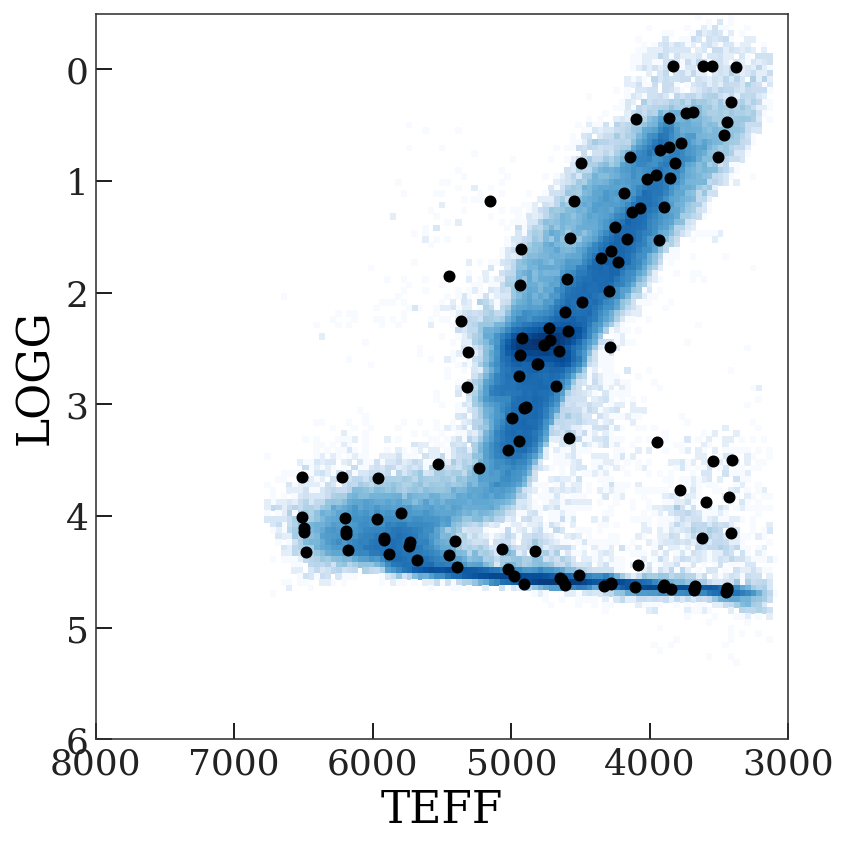

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.hist2d(allstar['TEFF'], allstar['LOGG'], 
          bins=plot_teff_logg_bins,
          norm=mpl.colors.LogNorm(),
          cmap='Blues');

ax.scatter(bin_means[:, 0],
           bin_means[:, 1],
           zorder=100)

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_xlabel('TEFF')
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Find the nearest bin:

In [78]:
eval_stars, eval_visits = get_visits(
    allstar, allvisit, LOGG=(-0.5, 6), TEFF=(3000, 8000))

metric = np.array([teff_step, logg_step])
kdtree = cKDTree(bin_means / metric)

## Evaluate at a specific SNR, M/H, VSINI:

In [79]:
dense_teff_ctrs = np.linspace(teff_ctrs.min(), teff_ctrs.max(), 256)
dense_logg_ctrs = np.linspace(logg_ctrs.min(), logg_ctrs.max(), 256)
dense_teff_grid, dense_logg_grid = np.meshgrid(dense_teff_ctrs, dense_logg_ctrs)

  0%|          | 0/117 [00:00<?, ?it/s]

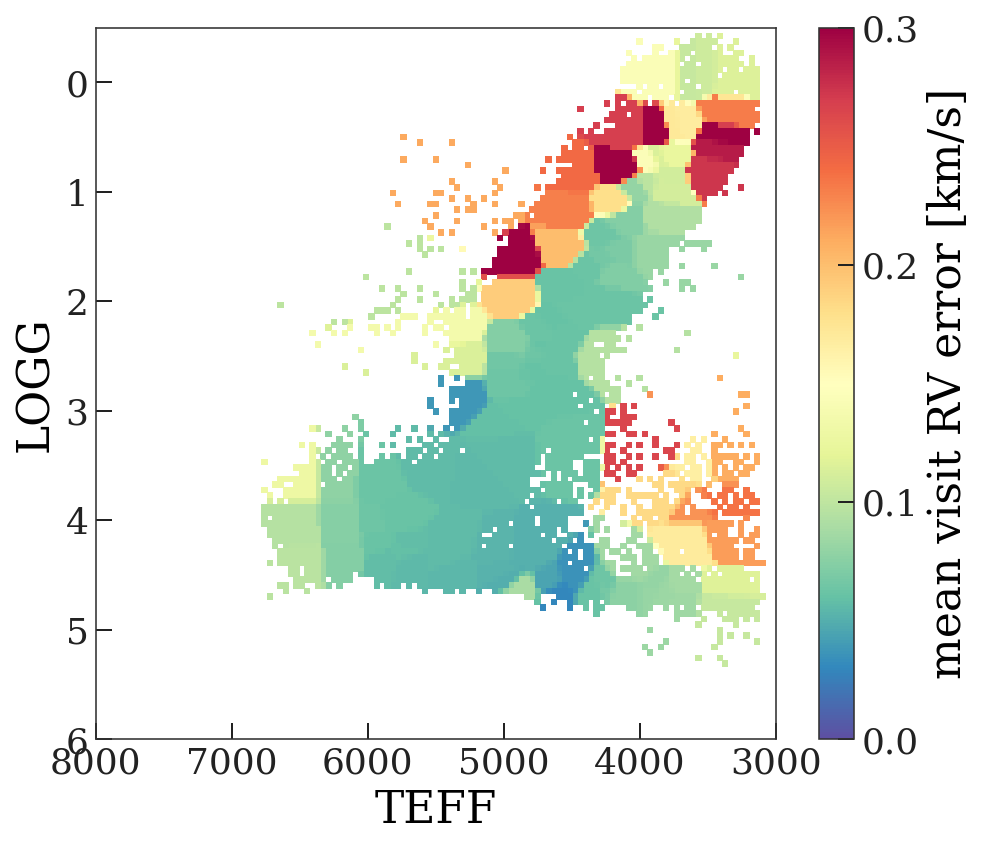

In [81]:
X = np.stack((dense_teff_grid.ravel(), dense_logg_grid.ravel())).T
dist, idx = kdtree.query(X / metric)

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), 100),
        'm_hs': np.full(idx_mask.sum(), 0),
#         'vsinis': np.full(idx_mask.sum(), 1),
        'ccfwhms': np.full(idx_mask.sum(), 0.),
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

# ---

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='mean')
H = stat.statistic

tmpH, *_ = np.histogram2d(
    allstar['TEFF'], 
    allstar['LOGG'], 
    bins=plot_teff_logg_bins)
H[tmpH < 1] = np.nan

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   H.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

## Evaluate for the APOGEE sample:

In [89]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
        # 'vsinis': eval_visits['VSINI'][idx_mask],
        'ccfwhms': eval_visits['CCFWHM'][idx_mask] - med_CCFWHM,
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(model.named_vars['err1'], 
                                              point=map_p)

  0%|          | 0/117 [00:00<?, ?it/s]

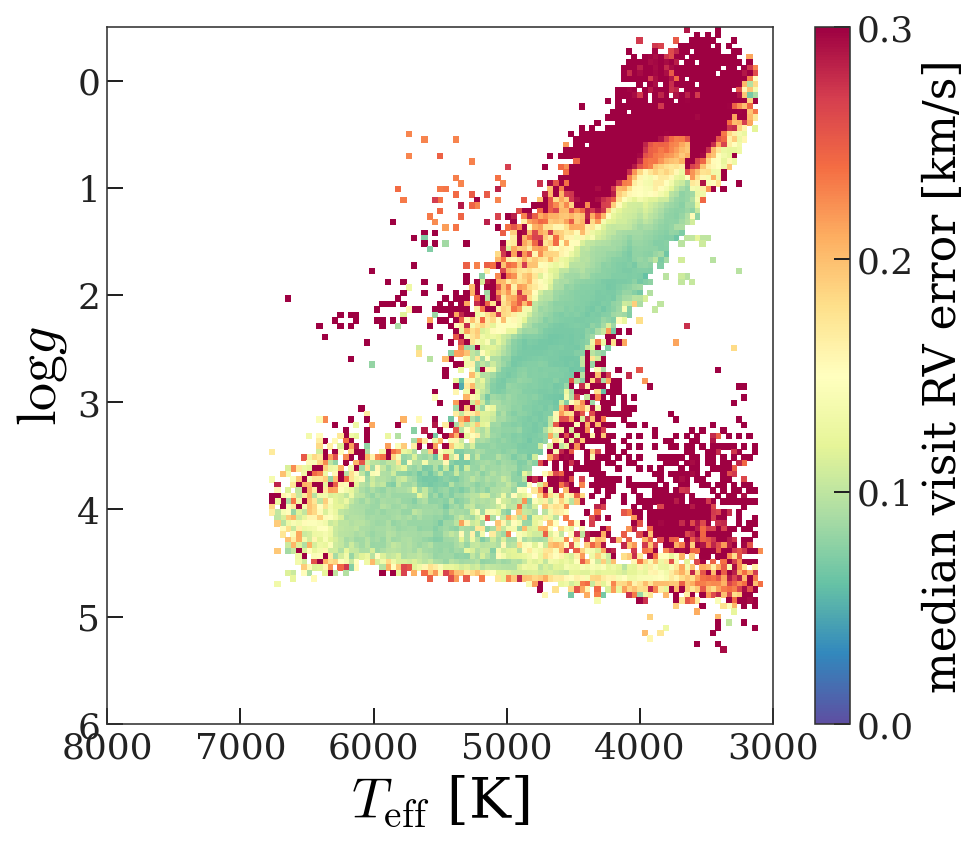

In [90]:
stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           all_errs, 
                           bins=plot_teff_logg_bins,
                           statistic=np.nanmedian)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r',
                   rasterized=True)

cb = fig.colorbar(cs)
cb.set_label('median visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlim(plot_teff_logg_bins[0].max(), plot_teff_logg_bins[0].min())
ax.set_ylim(plot_teff_logg_bins[1].max(), plot_teff_logg_bins[1].min())
ax.set_xlabel(r'$T_{\rm eff}$ [K]', fontsize=28)
ax.set_ylabel(r'$\log g$', fontsize=28)

fig.tight_layout()
fig.set_facecolor('w')

fig.savefig(figure_path / 'mean-visit-rv-err.pdf', dpi=250)

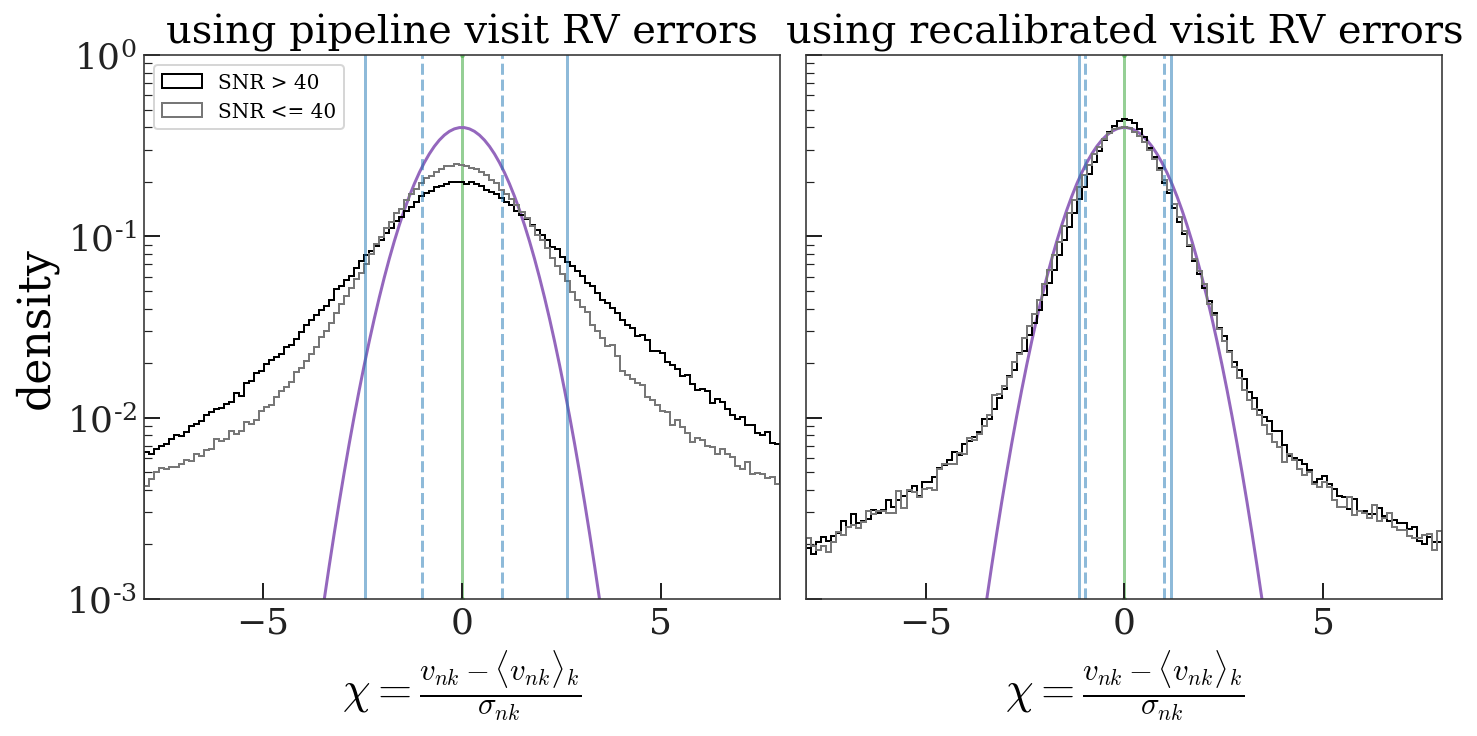

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5),
                         sharex=True, sharey=True,
                         constrained_layout=True)

for ax, err in zip(axes, [eval_visits['VRELERR'], all_errs]):
    chi = eval_visits['DVHELIO'] / err
    
    for line in [-1, 1]:
        ax.axvline(line, marker='', ls='--', color='tab:blue', alpha=0.5)    
    for line in np.percentile(chi, [16, 84]):
        ax.axvline(line, marker='', ls='-', color='tab:blue', alpha=0.5)

    snr_split = eval_visits['SNR'] > 40
    ax.hist(chi[snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True,
            label='SNR > 40', color='k')
    ax.hist(chi[~snr_split], 
            histtype='step',
            bins=np.linspace(-8, 8, 128), 
            density=True, 
            label='SNR <= 40', color='#777777')

    ax.set_xlabel(r'$\chi = \frac{v_{nk}-\langle v_{nk}\rangle_k}{\sigma_{nk}}$')
    ax.axvline(0, zorder=-10, alpha=0.5, color='tab:green')
    
    _grid = np.linspace(-8, 8, 128)
    ax.plot(_grid, norm.pdf(_grid, 0, 1.), 
            zorder=-1, color='tab:purple',
            marker='')

ax.set_xlim(-8, 8)
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e0)
axes[0].legend(loc='upper left')
axes[0].set_ylabel('density')

axes[0].set_title('using pipeline visit RV errors', fontsize=20)
axes[1].set_title('using recalibrated visit RV errors', fontsize=20)

fig.set_facecolor('w')
# fig.savefig(figure_path / 'chi-distr.pdf', dpi=250)

### Color tesselation by other model parameters:

  0%|          | 0/117 [00:00<?, ?it/s]

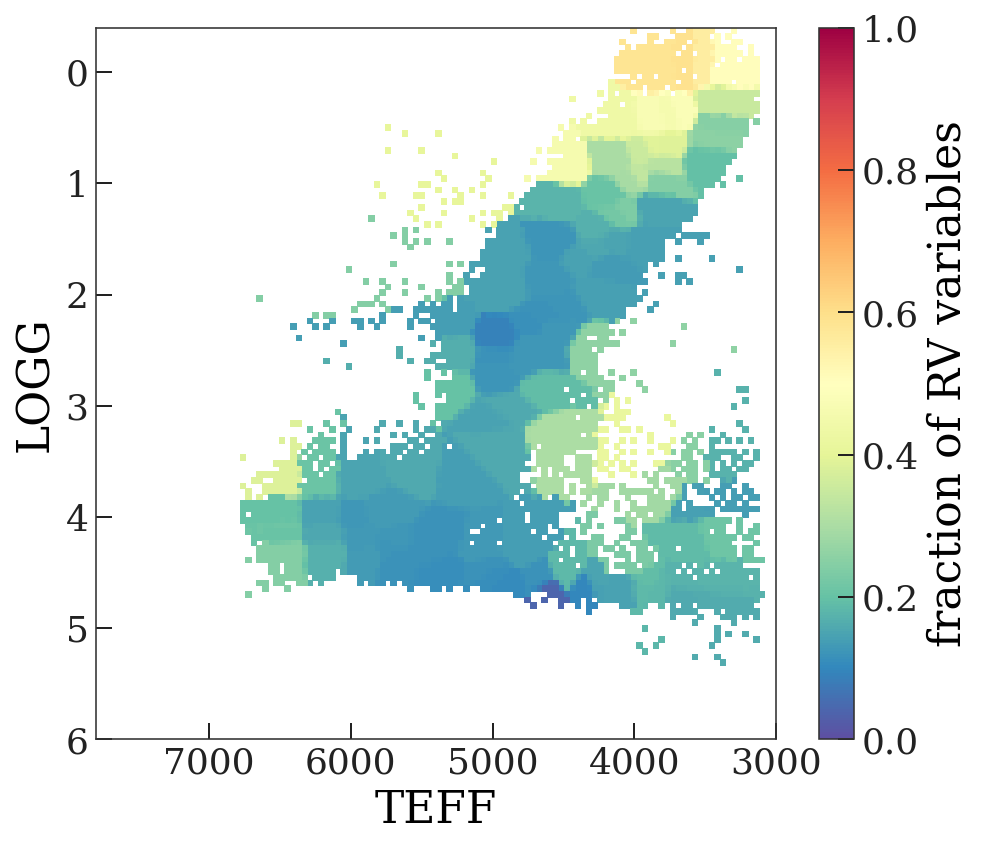

In [92]:
arr = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    arr[idx_mask] = sum(map_p['w'][1:])

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           arr, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=1,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('fraction of RV variables')

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At fixed metallicity:

  0%|          | 0/117 [00:00<?, ?it/s]

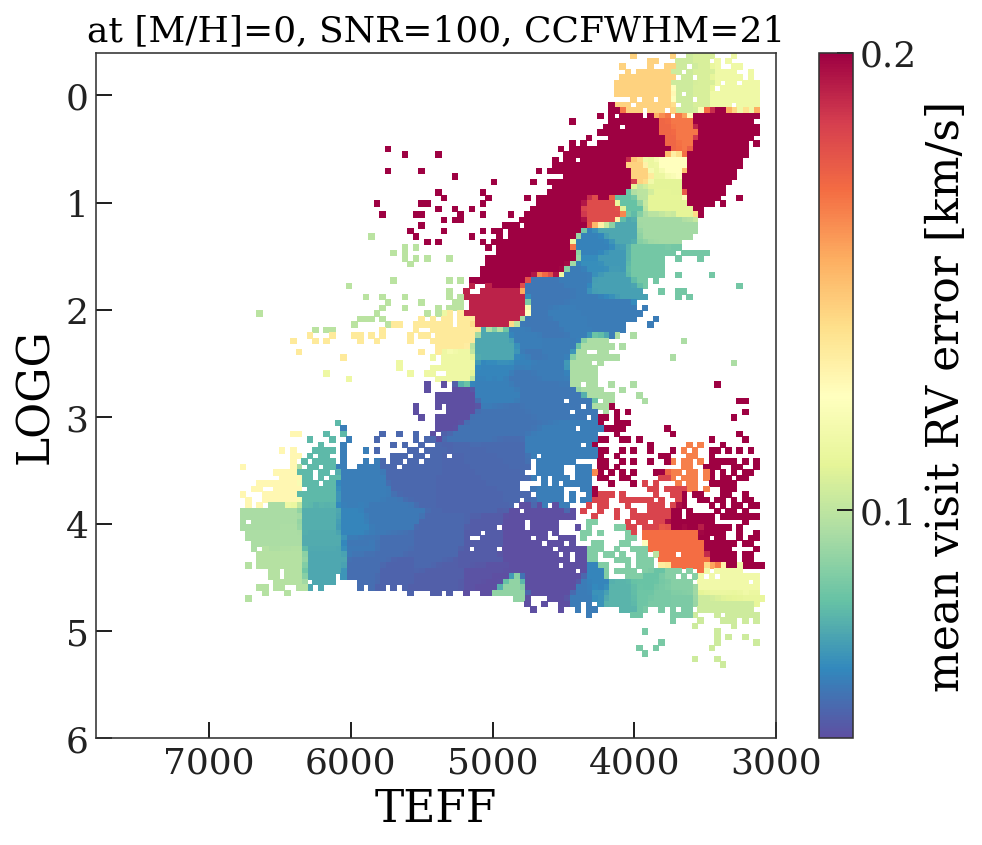

In [94]:
snr_plot = 100
# vsini_plot = 1.
ccfwhm_plot = 0.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        # 'vsinis': np.full(idx_mask.sum(), vsini_plot)
        'ccfwhms': np.full(idx_mask.sum(), ccfwhm_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins)

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.05, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, CCFWHM={ccfwhm_plot + med_CCFWHM:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### At low SNR

  0%|          | 0/117 [00:00<?, ?it/s]

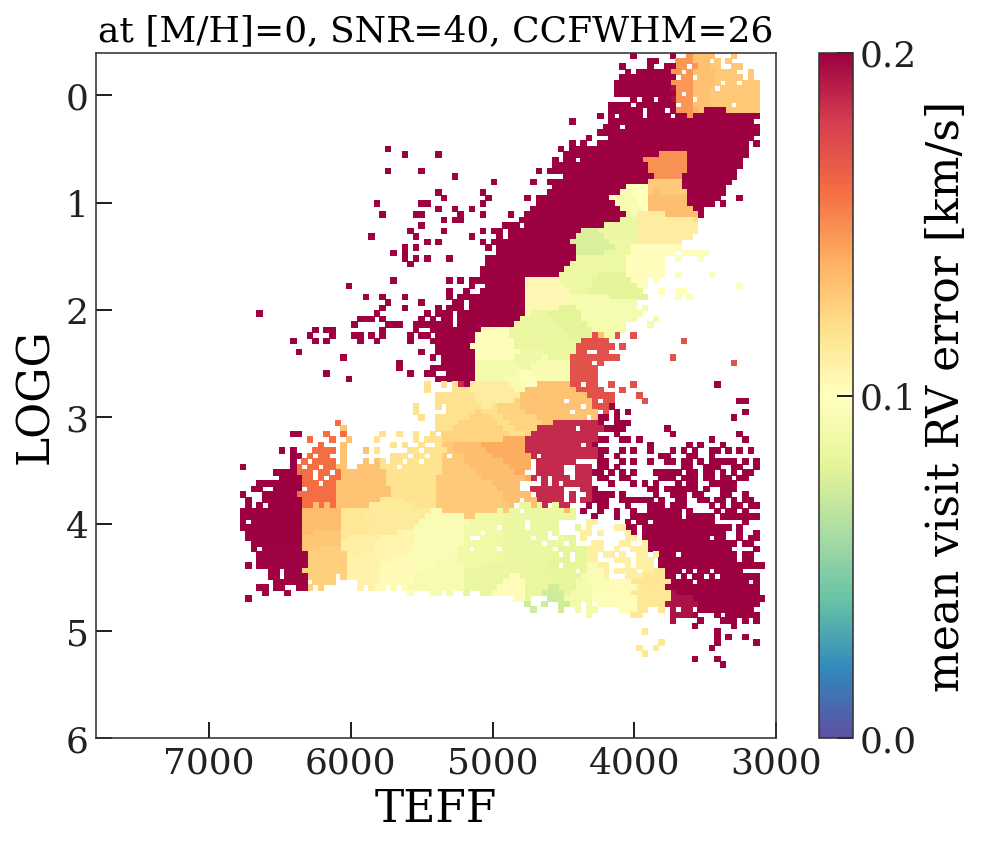

In [95]:
snr_plot = 40
ccfwhm_plot = 5.

tmp_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': np.full(idx_mask.sum(), snr_plot),
        'm_hs': np.full(idx_mask.sum(), 0.),
        # 'vsinis': np.full(idx_mask.sum(), vsini_plot)
        'ccfwhms': np.full(idx_mask.sum(), ccfwhm_plot)
    }

    with model:
        pm.set_data(eval_data)
        tmp_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                           tmp_errs, 
                           bins=plot_teff_logg_bins,
                           statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('mean visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))
ax.set_title(f'at [M/H]=0, SNR={snr_plot}, CCFWHM={ccfwhm_plot + med_CCFWHM:.0f}', fontsize=18)

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

### Plot all parameters on grid:

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

  0%|          | 0/117 [00:00<?, ?it/s]

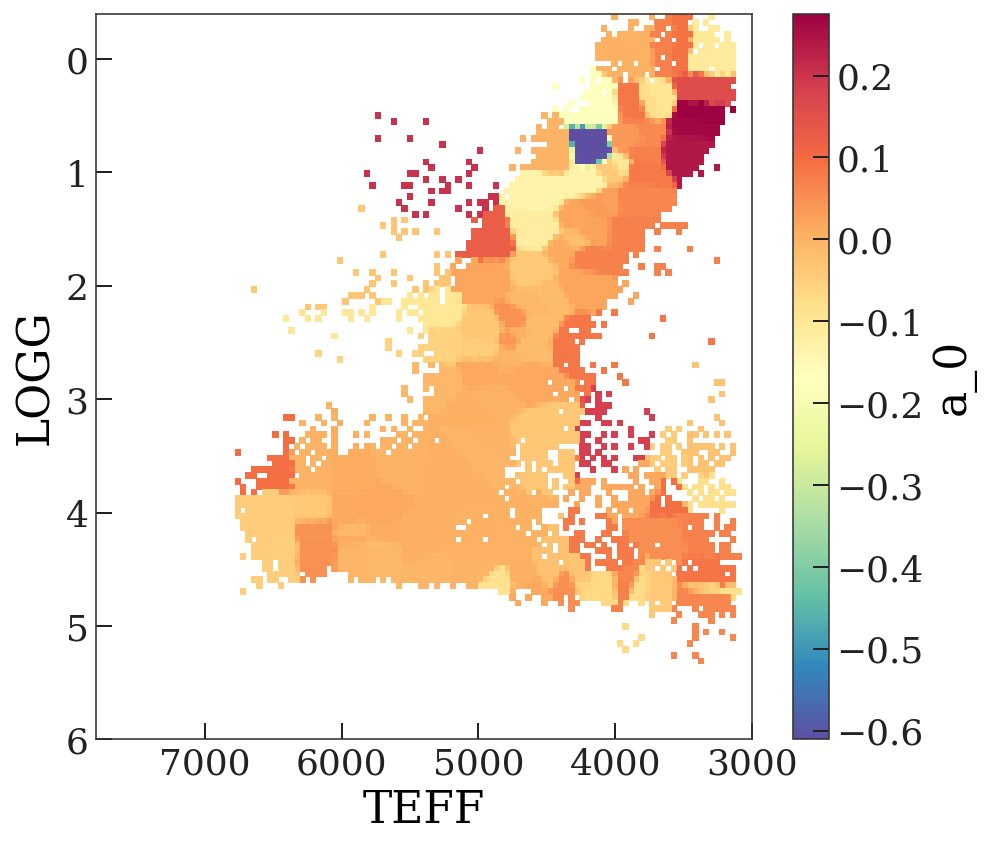

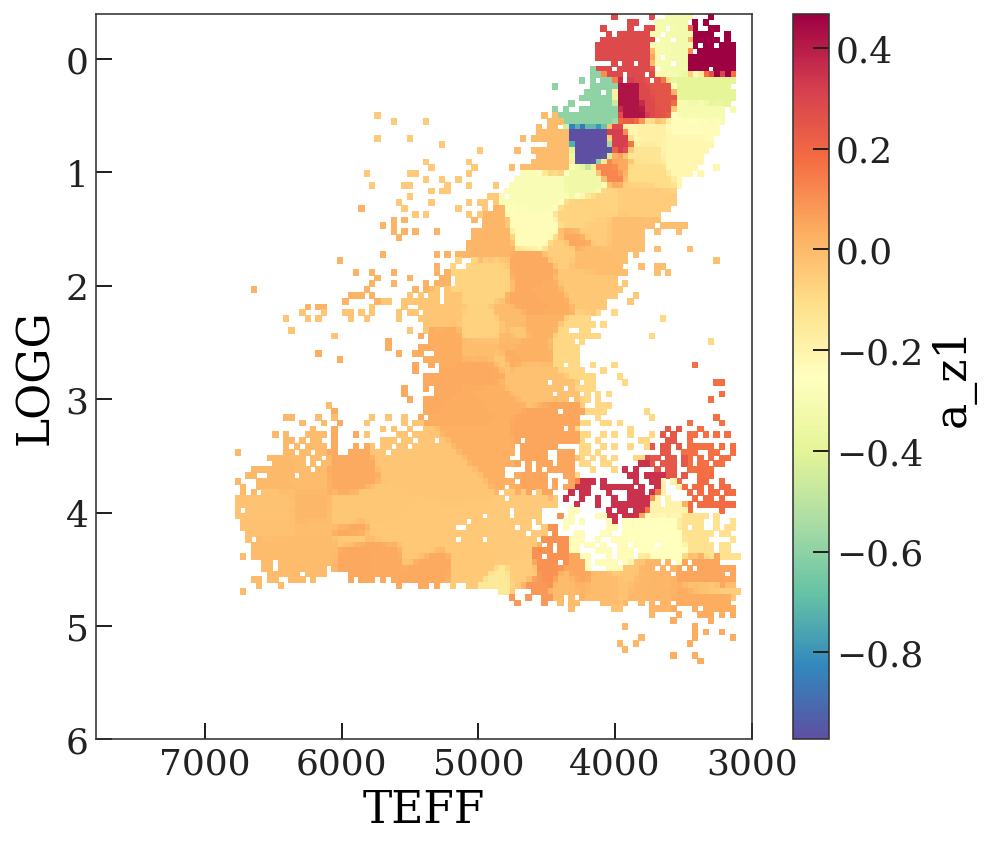

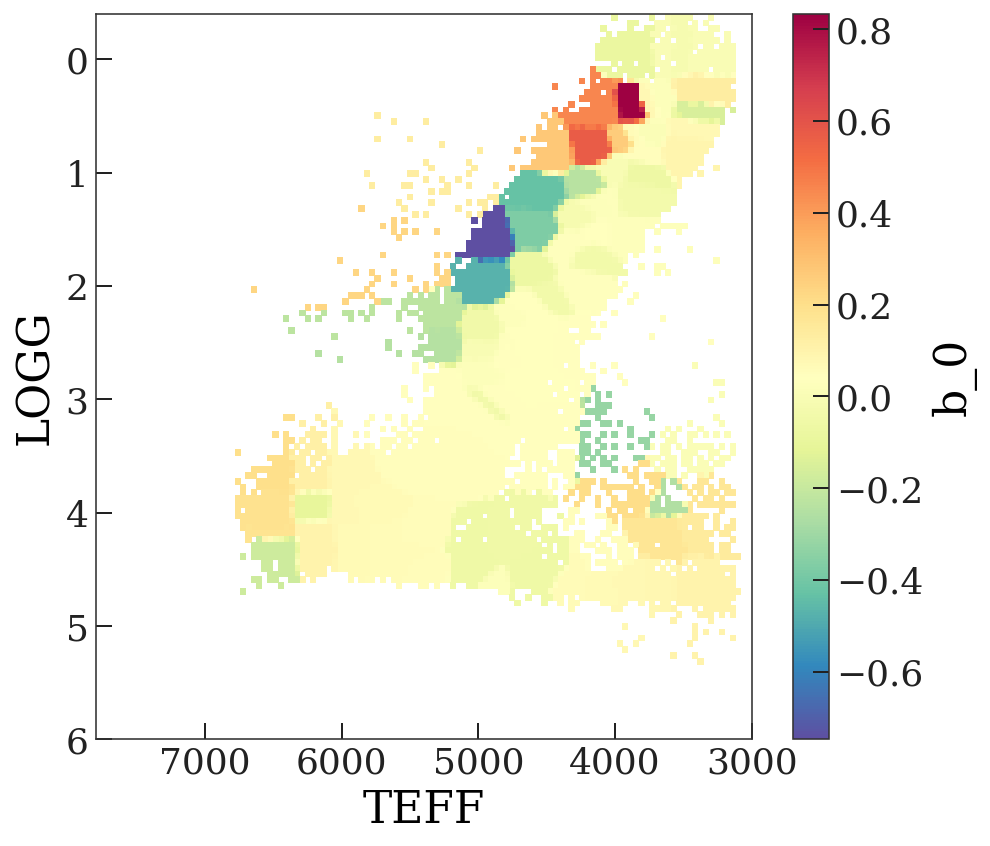

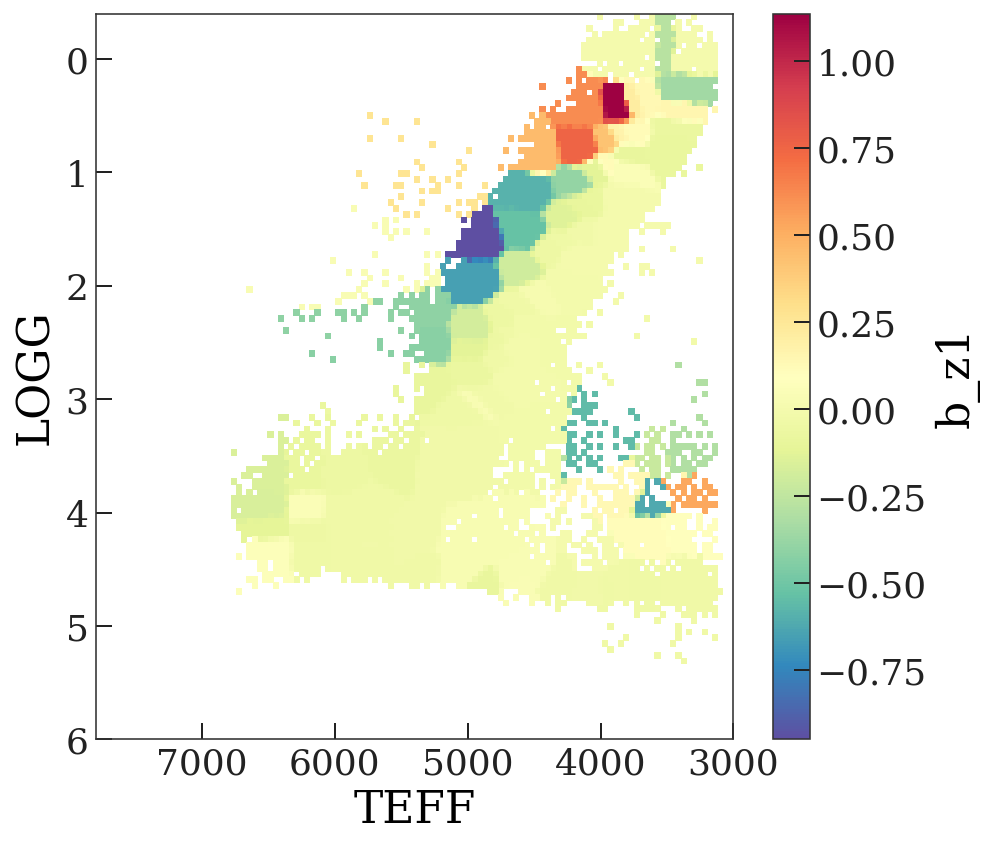

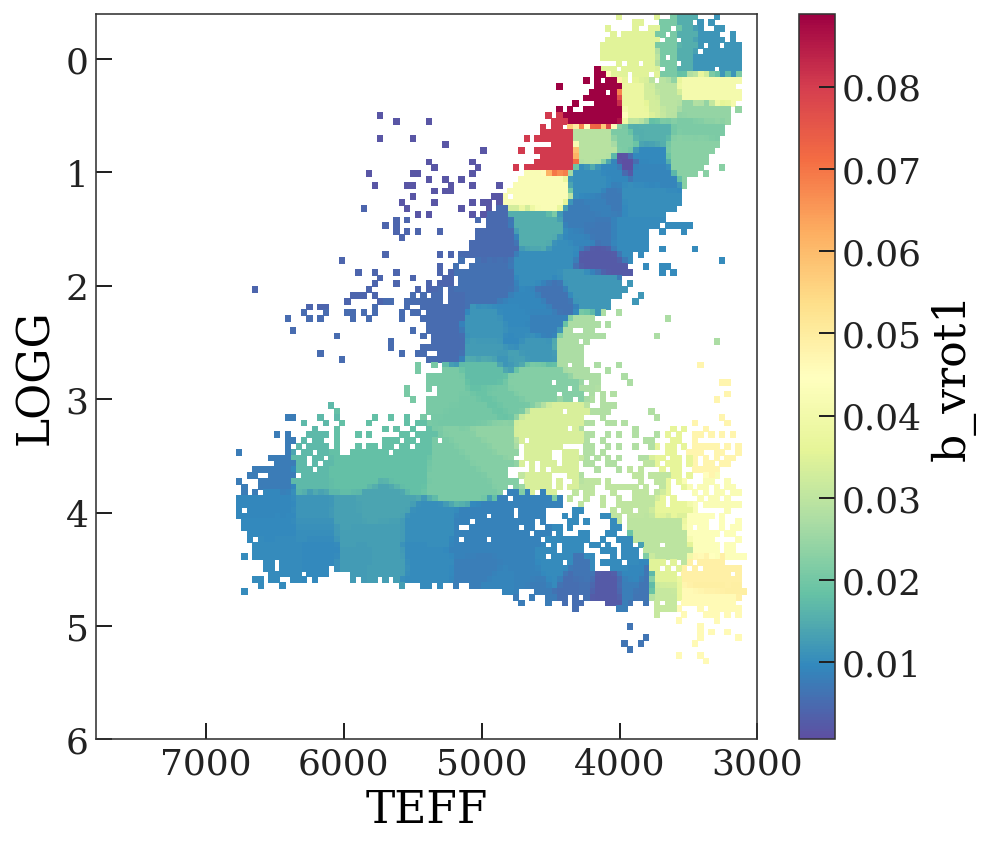

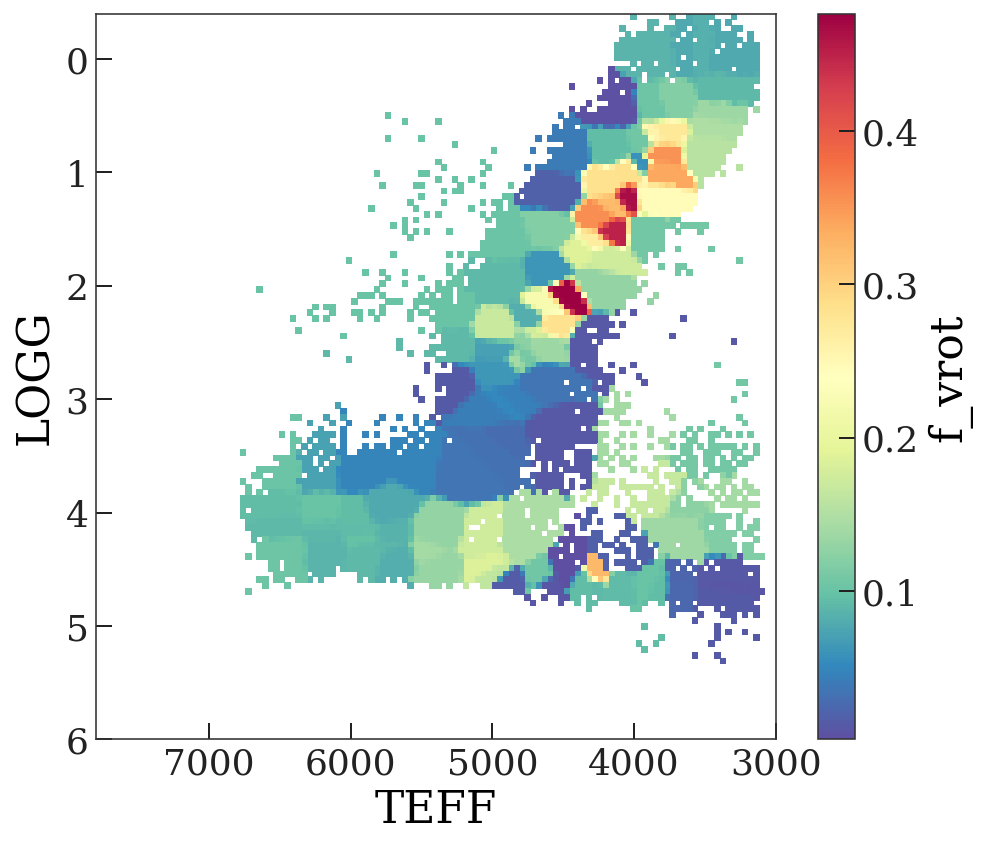

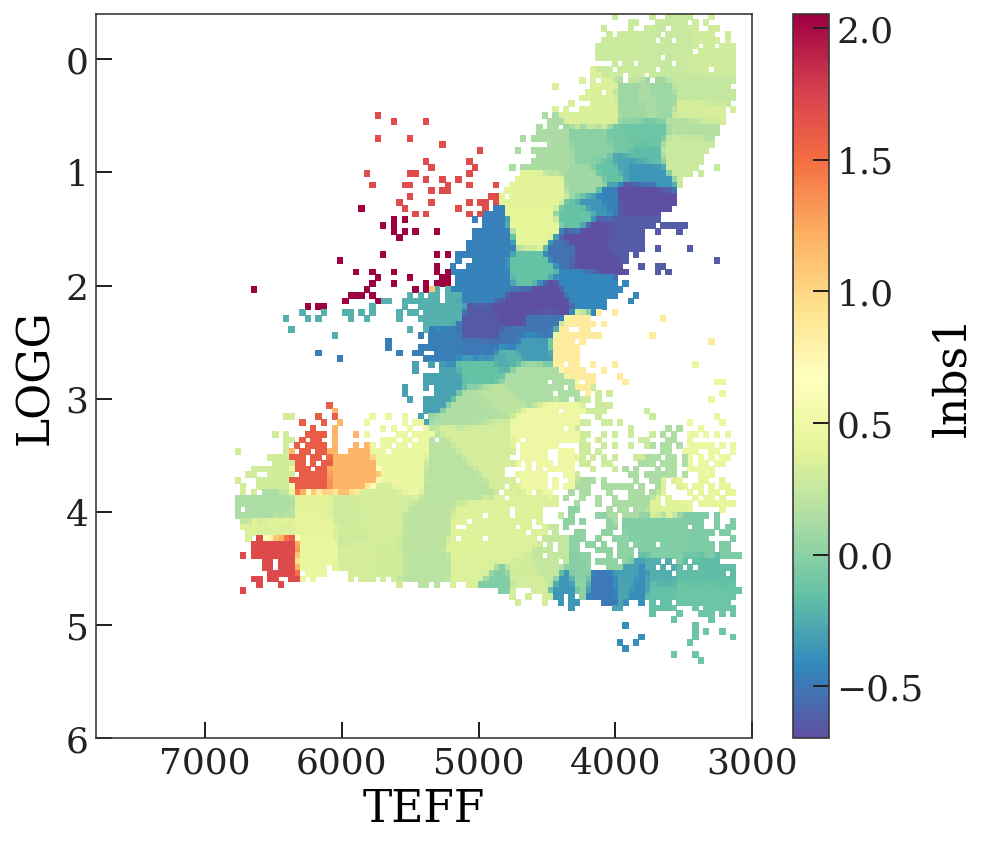

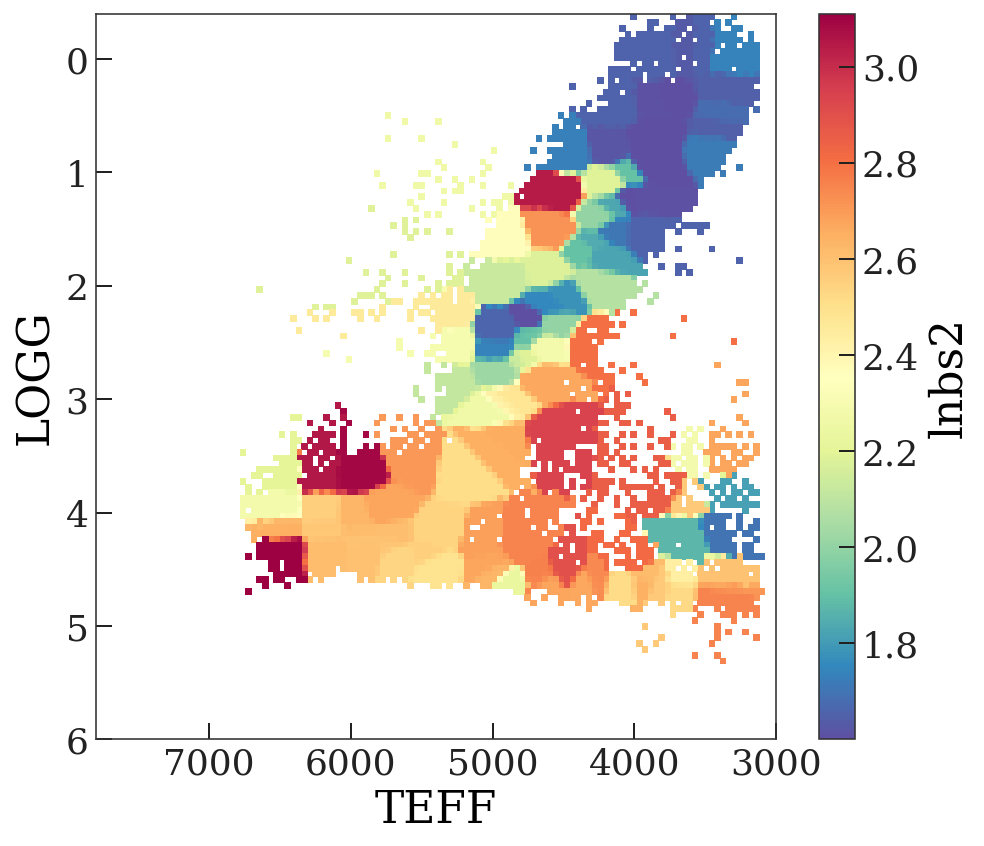

In [96]:
for param_name in ['a_0', 'a_z1',
                   'b_0', 'b_z1', 
                   'b_vrot1', 'f_vrot',
                   'lnbs1', 'lnbs2']:
    arr = np.full(len(idx), np.nan)
    for i in tqdm(np.unique(idx)):
        if i >= len(map_estimates):
            continue

        idx_mask = idx == i
        map_p = map_estimates[i]
        arr[idx_mask] = map_p[param_name]

    stat = binned_statistic_2d(X[:, 0], X[:, 1], 
                               arr, 
                               bins=plot_teff_logg_bins)

    fig, ax = plt.subplots(figsize=(7, 6))

    cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                       stat.statistic.T,
                       # vmin=0, vmax=1,
                       cmap='Spectral_r')

    cb = fig.colorbar(cs)
    cb.set_label(param_name)

    ax.set_xlabel('TEFF')
    ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
    ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
    ax.set_ylabel('LOGG')

    fig.tight_layout()
    fig.set_facecolor('w')

---

# Apply to the full allVisit file:

In [97]:
full_allstar = at.Table.read(allstar_file, hdu=1)
full_allvisit = at.Table.read(allvisit_file, hdu=1)

eval_stars, eval_visits = get_visits(
    full_allstar, full_allvisit,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6))

tmp_mask = np.all([np.isfinite(eval_visits[k]) 
                   for k in ['LOGG', 'TEFF', 'M_H', 'SNR', 'CCFWHM']], 
                  axis=0)
eval_visits = eval_visits[tmp_mask]

print(len(full_allstar), len(full_allvisit))
print(len(eval_stars), len(eval_visits))

733901 2659178
661329 2357735


In [110]:
X = np.stack((eval_visits['TEFF'], eval_visits['LOGG'])).T
metric = np.array([teff_step, logg_step])

kdtree = cKDTree(bin_means / metric)
dist, idx = kdtree.query(X / metric)

In [112]:
all_errs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'snrs': eval_visits['SNR'][idx_mask],
        # 'vsinis': eval_visits['VSINI'][idx_mask],
        'm_hs': eval_visits['M_H'][idx_mask],
        'ccfwhms': eval_visits['CCFWHM'][idx_mask] - med_CCFWHM,
    }

    with model:
        pm.set_data(eval_data)
        all_errs[idx_mask] = xo.eval_in_model(err1, point=map_p)

  0%|          | 0/117 [00:00<?, ?it/s]

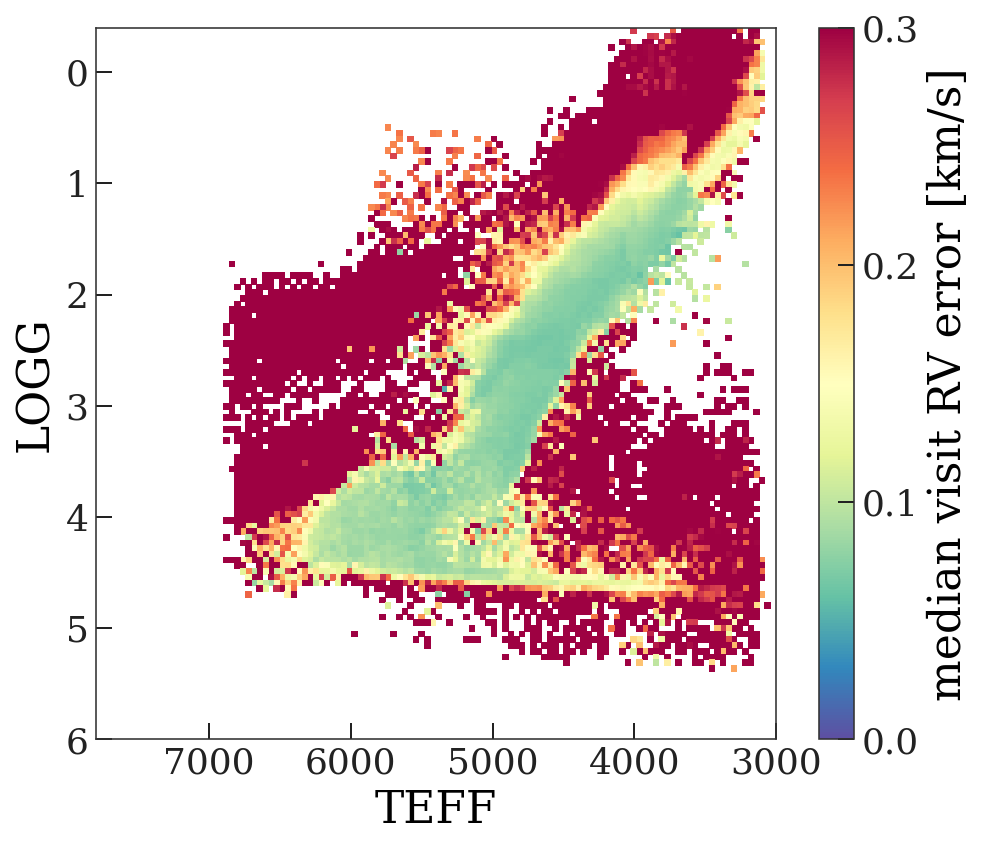

In [113]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='median')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0, vmax=0.3,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('median visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

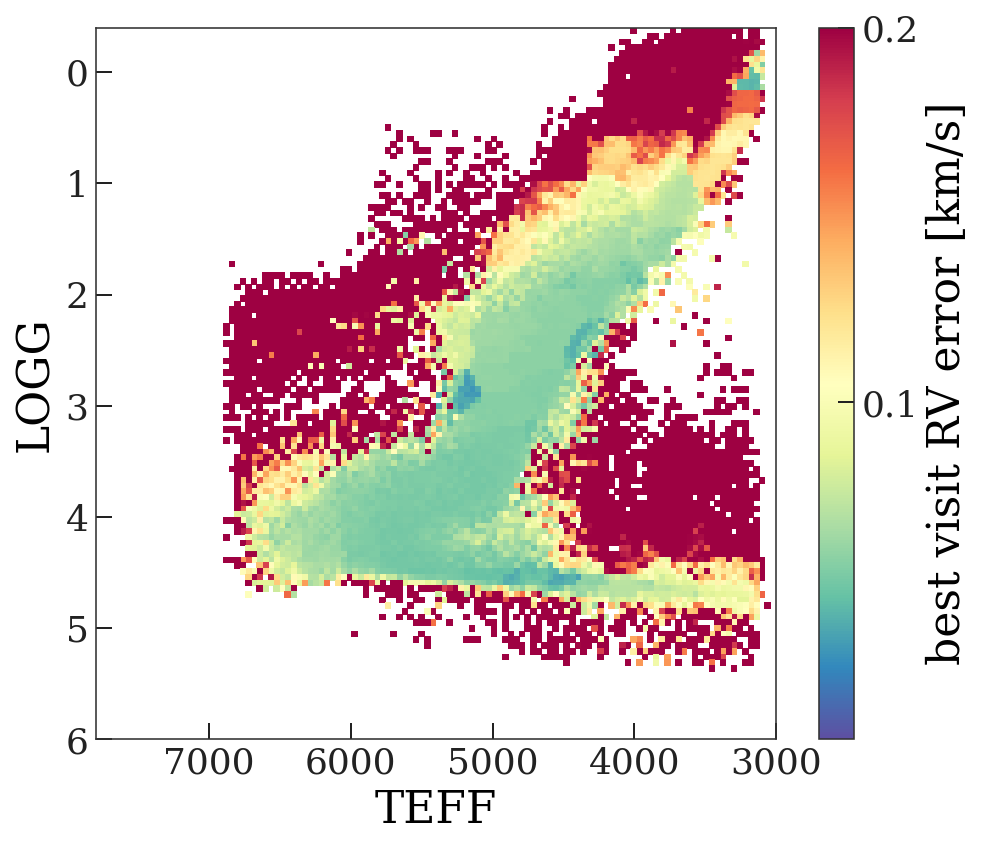

In [114]:
stat = binned_statistic_2d(
    X[:, 0], X[:, 1], 
    all_errs, 
    bins=plot_teff_logg_bins,
    statistic='min')

fig, ax = plt.subplots(figsize=(7, 6))

cs = ax.pcolormesh(stat.x_edge, stat.y_edge, 
                   stat.statistic.T,
                   vmin=0.01, vmax=0.2,
                   cmap='Spectral_r')

cb = fig.colorbar(cs)
cb.set_label('best visit RV error [km/s]')
cb.set_ticks(np.arange(0, 0.3+1e-3, 0.1))

ax.set_xlabel('TEFF')
ax.set_xlim(teff_ctrs.max(), teff_ctrs.min())
ax.set_ylim(logg_ctrs.max(), logg_ctrs.min())
ax.set_ylabel('LOGG')

fig.tight_layout()
fig.set_facecolor('w')

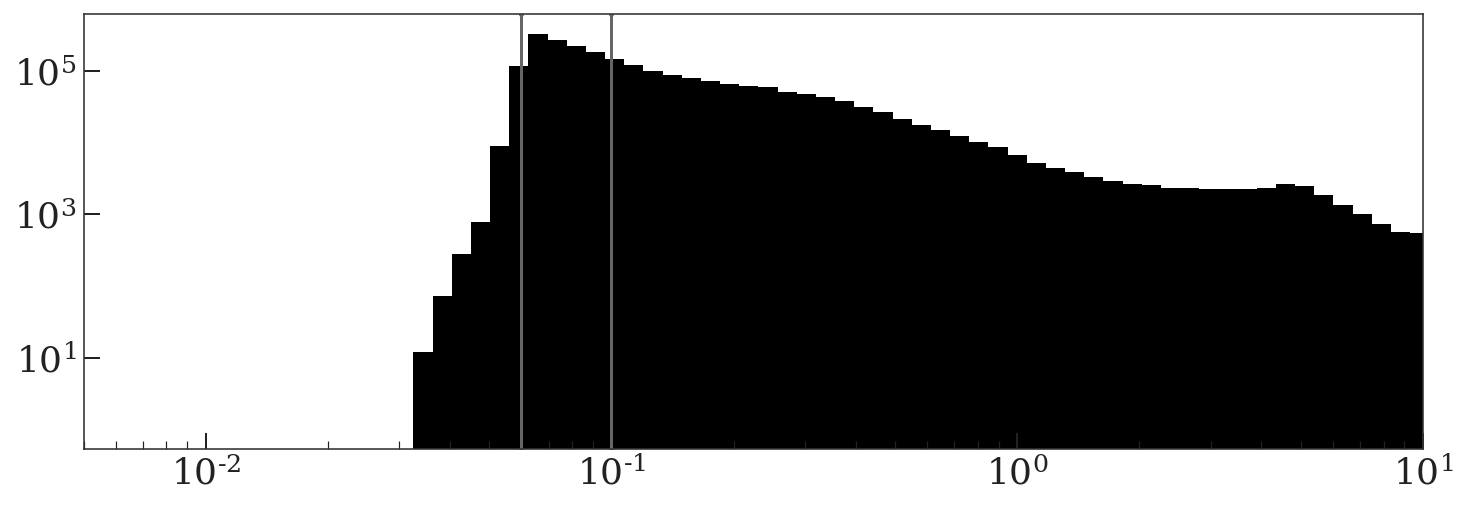

In [115]:
plt.figure(figsize=(12, 4))
plt.hist(all_errs, bins=np.geomspace(1e-3, 1e3, 128)); #.min()
plt.xticks(10. ** np.arange(-3, 2+1))
plt.xlim(5e-3, 1e1)
plt.axvline(0.1)
plt.axvline(0.06)
plt.xscale('log')
plt.yscale('log')

In [116]:
for q in [5, 25, 50, 75, 95]:
    xxx = np.percentile(all_errs, q) * 1e3
    print(f'{str(q).rjust(2)}% of visits have err < {xxx:.0f} m/s')

 5% of visits have err < 62 m/s
25% of visits have err < 73 m/s
50% of visits have err < 98 m/s
75% of visits have err < 183 m/s
95% of visits have err < 582 m/s


In [117]:
tbl = at.Table()
tbl['VISIT_ID'] = eval_visits['VISIT_ID']    
tbl['CALIB_VERR'] = np.clip(all_errs, None, 1e2)

basename = os.path.splitext(allvisit_file.parts[-1])[0]
calib_err_filename = f'../cache/{basename}-calib-verr.fits'
tbl.write(calib_err_filename, overwrite=True)

In [118]:
print(calib_err_filename)

../cache/allVisit-dr17-synspec-calib-verr.fits


---

# How many binaries?

OLD!

Note: this has to be run after running Make-parent-sample.ipynb:

In [456]:
parent_visits = at.Table.read('../cache/visits-dr17alpha-min3-calibverr.fits', 
                              hdu=1)

_, parent_visits = get_visits(
    full_allstar, parent_visits,
    TEFF=(2500, 8000), 
    LOGG=(-1, 6),
    M_H=(-4, 1),
    SNR=(2, 1e6),
    VSINI=(0, 50))

len(parent_visits)

1628155

In [458]:
X = np.stack((parent_visits['TEFF'], parent_visits['LOGG'])).T
dist, idx = kdtree.query(X / metric)

all_single_probs = np.full(len(idx), np.nan)
for i in tqdm(np.unique(idx)):
    if i >= len(map_estimates):
        continue
    
    idx_mask = idx == i
    map_p = map_estimates[i]
    
    eval_data = {
        'vs': np.array(parent_visits['DVHELIO'][idx_mask]),
        'snrs': np.array(parent_visits['SNR'][idx_mask]),
        'm_hs': np.array(parent_visits['M_H'][idx_mask]),
        'vsinis': np.array(parent_visits['VSINI'][idx_mask]),
    }

    with model:
        pm.set_data(eval_data)
        logps = [xo.eval_in_model(model.named_vars[f'logp{i+1}'], 
                                  point=map_p) + map_p['w'][i]
                 for i in range(3)]
    
    all_single_probs[idx_mask] = np.exp(logps[0] - logsumexp(logps, axis=0))

  0%|          | 0/136 [00:00<?, ?it/s]

In [460]:
tmp = at.Table()
tmp['apogee_id'] = parent_visits['APOGEE_ID']
tmp['prob'] = 1 - all_single_probs
tmp = tmp[np.isfinite(parent_visits['DVHELIO']) & (parent_visits['DVHELIO'] != 0)]
tmpdf = tmp.to_pandas()
len(tmpdf)

1628155

In [461]:
gdf = tmpdf.groupby('apogee_id').mean()
(gdf['prob'] > 0.25).sum(), (gdf['prob'] > 0.5).sum(), (gdf['prob'] > 0.8).sum()

(67358, 42790, 28822)